### Scatter plots

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
from importlib import reload
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
# Open HadISST for caculating Nino3.4 index 
hadisst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/hadisstv1.1870_2017.nc')
sst_data = hadisst_ds.sst

In [ ]:
# Detrend HadISST data
sst_data_detrend = np.apply_along_axis(func.detrend_2step, 0, sst_data)
sst_detrended = xr.DataArray(sst_data_detrend, coords=sst_data.coords, attrs=sst_data.attrs)

In [ ]:
# Nino3.4 index with HadiSSTv1
nino34_region = sst_detrended.sel(latitude=slice(5,-5), longitude=slice(-170,-120))
climatology = nino34_region.sel(time=slice('1950-01','1979-12')).groupby('time.month').mean()
monthly_anomalies = (nino34_region.groupby('time.month')-climatology).mean(dim=['latitude','longitude'])
monthly_anomalies_rolling = monthly_anomalies.rolling(time=5).mean()
sst_std = nino34_region.sel(time=slice('1950-01','1979-12')).std()
nino34_index = monthly_anomalies_rolling.sel(time=slice('1901-6', '2015-5'))/sst_std

In [ ]:
func.seasonyear(nino34_index)
seasonal_nino = nino34_index.groupby('seasonyear').apply(func.seasonal_mean)

In [ ]:
nino_djf=seasonal_nino.sel(season='DJF')

In [ ]:
pos_nino = nino_djf.where(nino_djf>0, drop=True)
neg_nino = nino_djf.where(nino_djf<0, drop=True)

In [ ]:
# Save nino as netcdfs 
pos_nino.to_netcdf('pos_nino.nc')
neg_nino.to_netcdf('neg_nino.nc')

In [2]:
# Open nino 
pos_nino = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/pos_nino.nc')
neg_nino = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/neg_nino.nc')

### Mean temperature composites 

In [ ]:
# Open detrended mean temp anomalies from 20CR 
tmp = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(tmp)
# Calculate seasonal means 
seasonal_tmp = tmp.groupby('seasonyear').apply(func.seasonal_mean)

In [ ]:
#select out each season
tmp_jja = seasonal_tmp.sel(season='JJA')
tmp_son = seasonal_tmp.sel(season='SON')
tmp_djf = seasonal_tmp.sel(season='DJF')
tmp_mam = seasonal_tmp.sel(season='MAM')

In [ ]:
# Select out regional boxes and take lat long mean  
east_aus = tmp_djf.sel(latitude=slice(-10,-40)).sel(longitude=slice(139,154)).mean(dim=['latitude','longitude'])
south_africa = tmp_djf.sel(latitude=slice(-20,-30)).sel(longitude=slice(20,30)).mean(dim=['latitude','longitude'])
south_america = tmp_djf.sel(latitude=slice(10,-10)).sel(longitude=slice(-80,-50)).mean(dim=['latitude','longitude'])

In [ ]:
# Seperate into positive and negative halves 
east_aus_pos_nino_tmp = east_aus.where(nino_djf>0, drop=True)
east_aus_neg_nino_tmp = east_aus.where(nino_djf<0, drop=True)
south_africa_pos_nino_tmp = south_africa.where(nino_djf>0, drop=True)
south_africa_neg_nino_tmp = south_africa.where(nino_djf<0, drop=True)
south_america_pos_nino_tmp = south_america.where(nino_djf>0, drop=True)
south_america_neg_nino_tmp = south_america.where(nino_djf<0, drop=True)

In [ ]:
# Save data as netcdfs 
east_aus_pos_nino_tmp.to_netcdf('east_aus_pos_nino_tmp.nc')
east_aus_neg_nino_tmp.to_netcdf('east_aus_neg_nino_tmp.nc')
south_africa_pos_nino_tmp.to_netcdf('south_africa_pos_nino_tmp.nc')
south_africa_neg_nino_tmp.to_netcdf('south_africa_neg_nino_tmp.nc')
south_america_pos_nino_tmp.to_netcdf('south_america_pos_nino_tmp.nc')
south_america_neg_nino_tmp.to_netcdf('south_america_neg_nino_tmp.nc')

In [3]:
# Open data 
east_aus_pos_nino_tmp = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_pos_nino_tmp.nc')
east_aus_neg_nino_tmp = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_neg_nino_tmp.nc')
south_africa_pos_nino_tmp = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_pos_nino_tmp.nc')
south_africa_neg_nino_tmp = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_neg_nino_tmp.nc')
south_america_pos_nino_tmp = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_pos_nino_tmp.nc')
south_america_neg_nino_tmp = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_neg_nino_tmp.nc')

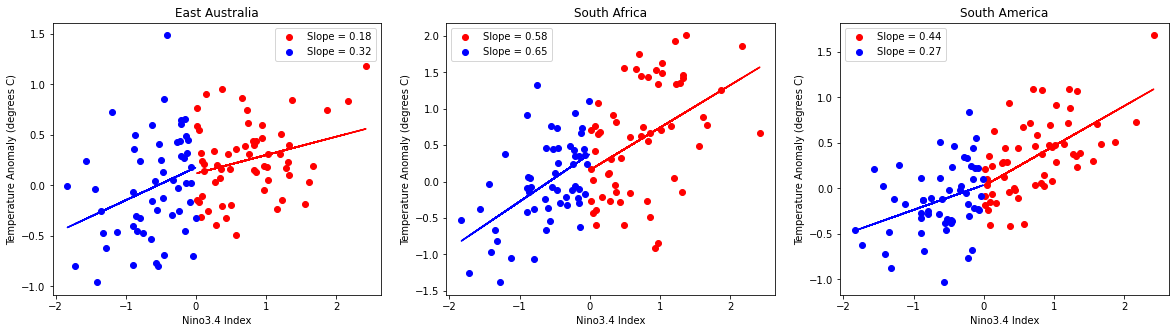

In [17]:
fig=plt.figure(figsize=(20,5))

# East Aus 
ax1=fig.add_subplot(131)
m, b = np.polyfit(pos_nino, east_aus_pos_nino_tmp.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, east_aus_neg_nino_tmp.mean(dim='member'), 1)
ax1.scatter(pos_nino, east_aus_pos_nino_tmp.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax1.scatter(neg_nino, east_aus_neg_nino_tmp.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax1.plot(pos_nino, m*pos_nino + b, c='r')
ax1.plot(neg_nino, k*neg_nino + c, c='b')
ax1.title.set_text('East Australia')
ax1.set_xlabel('Nino3.4 Index')
ax1.set_ylabel('Temperature Anomaly (degrees C)')
ax1.legend()

# South Africa 
ax2=fig.add_subplot(132)
m, b = np.polyfit(pos_nino, south_africa_pos_nino_tmp.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_africa_neg_nino_tmp.mean(dim='member'), 1)
ax2.scatter(pos_nino, south_africa_pos_nino_tmp.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax2.scatter(neg_nino, south_africa_neg_nino_tmp.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax2.plot(pos_nino, m*pos_nino + b, c='r')
ax2.plot(neg_nino, k*neg_nino + c, c='b')
ax2.title.set_text('South Africa')
ax2.set_xlabel('Nino3.4 Index')
ax2.set_ylabel('Temperature Anomaly (degrees C)')
ax2.legend()

# South America 
ax3=fig.add_subplot(133)
m, b = np.polyfit(pos_nino, south_america_pos_nino_tmp.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_america_neg_nino_tmp.mean(dim='member'), 1)
ax3.scatter(pos_nino, south_america_pos_nino_tmp.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax3.scatter(neg_nino, south_america_neg_nino_tmp.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax3.plot(pos_nino, m*pos_nino + b, c='r')
ax3.plot(neg_nino, k*neg_nino + c, c='b')
ax3.title.set_text('South America')
ax3.set_xlabel('Nino3.4 Index')
ax3.set_ylabel('Temperature Anomaly (degrees C)')
ax3.legend()

# plt.savefig('asymmetry_tmp_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Mean precipitation composites 

In [ ]:
# Open precip anomalies from 20CR 
prate = xr.open_dataarray('/g/data/w40/rl5183/progress_files/anom_prate.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(prate)
# Calculate seasonal means 
seasonal_prate = prate.groupby('seasonyear').apply(func.seasonal_mean)

In [ ]:
#select out each season
prate_jja = seasonal_prate.sel(season='JJA')
prate_son = seasonal_prate.sel(season='SON')
prate_djf = seasonal_prate.sel(season='DJF')
prate_mam = seasonal_prate.sel(season='MAM')

In [ ]:
# Select out regional boxes and take lat long mean  
east_aus = prate_djf.sel(latitude=slice(-10,-40)).sel(longitude=slice(139,154)).mean(dim=['latitude','longitude'])
south_africa = prate_djf.sel(latitude=slice(-20,-30)).sel(longitude=slice(20,30)).mean(dim=['latitude','longitude'])
south_america = prate_djf.sel(latitude=slice(10,-10)).sel(longitude=slice(-80,-50)).mean(dim=['latitude','longitude'])

In [ ]:
# Seperate into positive and negative halves 
east_aus_pos_nino_prate = east_aus.where(nino_djf>0, drop=True)
east_aus_neg_nino_prate = east_aus.where(nino_djf<0, drop=True)
south_africa_pos_nino_prate = south_africa.where(nino_djf>0, drop=True)
south_africa_neg_nino_prate = south_africa.where(nino_djf<0, drop=True)
south_america_pos_nino_prate = south_america.where(nino_djf>0, drop=True)
south_america_neg_nino_prate = south_america.where(nino_djf<0, drop=True)

In [ ]:
# Save data as netcdfs 
east_aus_pos_nino_prate.to_netcdf('east_aus_pos_nino_prate.nc')
east_aus_neg_nino_prate.to_netcdf('east_aus_neg_nino_prate.nc')
south_africa_pos_nino_prate.to_netcdf('south_africa_pos_nino_prate.nc')
south_africa_neg_nino_prate.to_netcdf('south_africa_neg_nino_prate.nc')
south_america_pos_nino_prate.to_netcdf('south_america_pos_nino_prate.nc')
south_america_neg_nino_prate.to_netcdf('south_america_neg_nino_prate.nc')

In [5]:
# Open data 
east_aus_pos_nino_prate = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_pos_nino_prate.nc')
east_aus_neg_nino_prate = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_neg_nino_prate.nc')
south_africa_pos_nino_prate = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_pos_nino_prate.nc')
south_africa_neg_nino_prate = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_neg_nino_prate.nc')
south_america_pos_nino_prate = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_pos_nino_prate.nc')
south_america_neg_nino_prate = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_neg_nino_prate.nc')

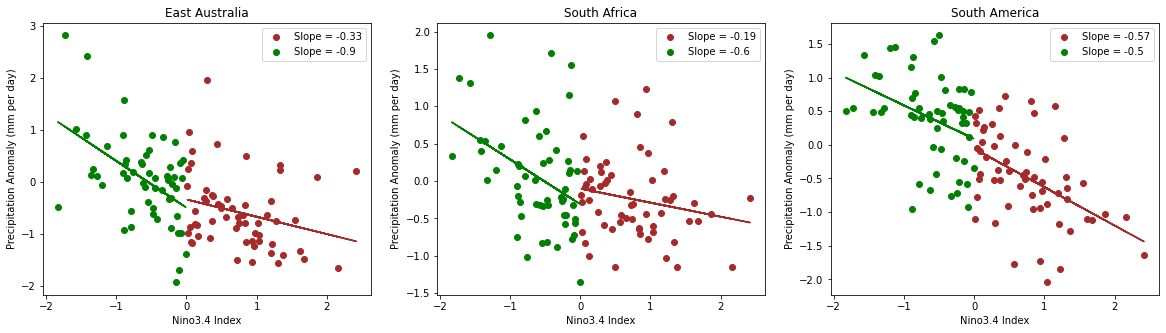

In [19]:
fig=plt.figure(figsize=(20,5))

# East Aus 
ax1=fig.add_subplot(131)
m, b = np.polyfit(pos_nino, east_aus_pos_nino_prate.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, east_aus_neg_nino_prate.mean(dim='member'), 1)
ax1.scatter(pos_nino, east_aus_pos_nino_prate.mean(dim='member'), c='brown', label=f'Slope = {round(m, 2)}')
ax1.scatter(neg_nino, east_aus_neg_nino_prate.mean(dim='member'), c='green', label=f'Slope = {round(k, 2)}')
ax1.plot(pos_nino, m*pos_nino + b, c='brown')
ax1.plot(neg_nino, k*neg_nino + c, c='green')
ax1.title.set_text('East Australia')
ax1.set_xlabel('Nino3.4 Index')
ax1.set_ylabel('Precipitation Anomaly (mm per day)')
ax1.legend()

# South Africa 
ax2=fig.add_subplot(132)
m, b = np.polyfit(pos_nino, south_africa_pos_nino_prate.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_africa_neg_nino_prate.mean(dim='member'), 1)
ax2.scatter(pos_nino, south_africa_pos_nino_prate.mean(dim='member'), c='brown', label=f'Slope = {round(m, 2)}')
ax2.scatter(neg_nino, south_africa_neg_nino_prate.mean(dim='member'), c='green', label=f'Slope = {round(k, 2)}')
ax2.plot(pos_nino, m*pos_nino + b, c='brown')
ax2.plot(neg_nino, k*neg_nino + c, c='green')
ax2.title.set_text('South Africa')
ax2.set_xlabel('Nino3.4 Index')
ax2.set_ylabel('Precipitation Anomaly (mm per day)')
ax2.legend()

# South America 
ax3=fig.add_subplot(133)
m, b = np.polyfit(pos_nino, south_america_pos_nino_prate.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_america_neg_nino_prate.mean(dim='member'), 1)
ax3.scatter(pos_nino, south_america_pos_nino_prate.mean(dim='member'), c='brown', label=f'Slope = {round(m, 2)}')
ax3.scatter(neg_nino, south_america_neg_nino_prate.mean(dim='member'), c='green', label=f'Slope = {round(k, 2)}')
ax3.plot(pos_nino, m*pos_nino + b, c='brown')
ax3.plot(neg_nino, k*neg_nino + c, c='green')
ax3.title.set_text('South America')
ax3.set_xlabel('Nino3.4 Index')
ax3.set_ylabel('Precipitation Anomaly (mm per day)')
ax3.legend()

# plt.savefig('asymmetry_prate_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### TXx composites

In [ ]:
TXx = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TXx_detrended.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(TXx)
# Calculate seasonal means 
seasonal_TXx = TXx.groupby('seasonyear').apply(func.seasonal_max)

In [ ]:
#select out each season
TXx_jja = seasonal_TXx.sel(season='JJA')
TXx_son = seasonal_TXx.sel(season='SON')
TXx_djf = seasonal_TXx.sel(season='DJF')
TXx_mam = seasonal_TXx.sel(season='MAM')

In [ ]:
# Select out regional boxes and take lat long mean  
east_aus = TXx_djf.sel(lat=slice(-40,-10)).sel(lon=slice(139,154)).mean(dim=['lat','lon'])
south_africa = TXx_djf.sel(lat=slice(-30,-20)).sel(lon=slice(20,30)).mean(dim=['lat','lon'])
south_america = TXx_djf.sel(lat=slice(-10,10)).sel(lon=slice(280,310)).mean(dim=['lat','lon'])

In [ ]:
# Seperate into positive and negative halves 
east_aus_pos_nino_TXx = east_aus.where(nino_djf>0, drop=True)
east_aus_neg_nino_TXx = east_aus.where(nino_djf<0, drop=True)
south_africa_pos_nino_TXx = south_africa.where(nino_djf>0, drop=True)
south_africa_neg_nino_TXx = south_africa.where(nino_djf<0, drop=True)
south_america_pos_nino_TXx = south_america.where(nino_djf>0, drop=True)
south_america_neg_nino_TXx = south_america.where(nino_djf<0, drop=True)

In [ ]:
# Save data as netcdfs 
east_aus_pos_nino_TXx.to_netcdf('east_aus_pos_nino_TXx.nc')
east_aus_neg_nino_TXx.to_netcdf('east_aus_neg_nino_TXx.nc')
south_africa_pos_nino_TXx.to_netcdf('south_africa_pos_nino_TXx.nc')
south_africa_neg_nino_TXx.to_netcdf('south_africa_neg_nino_TXx.nc')
south_america_pos_nino_TXx.to_netcdf('south_america_pos_nino_TXx.nc')
south_america_neg_nino_TXx.to_netcdf('south_america_neg_nino_TXx.nc')

In [7]:
east_aus_pos_nino_TXx = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_pos_nino_TXx.nc')
east_aus_neg_nino_TXx = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_neg_nino_TXx.nc')
south_africa_pos_nino_TXx = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_pos_nino_TXx.nc')
south_africa_neg_nino_TXx = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_neg_nino_TXx.nc')
south_america_pos_nino_TXx = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_pos_nino_TXx.nc')
south_america_neg_nino_TXx = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_neg_nino_TXx.nc')

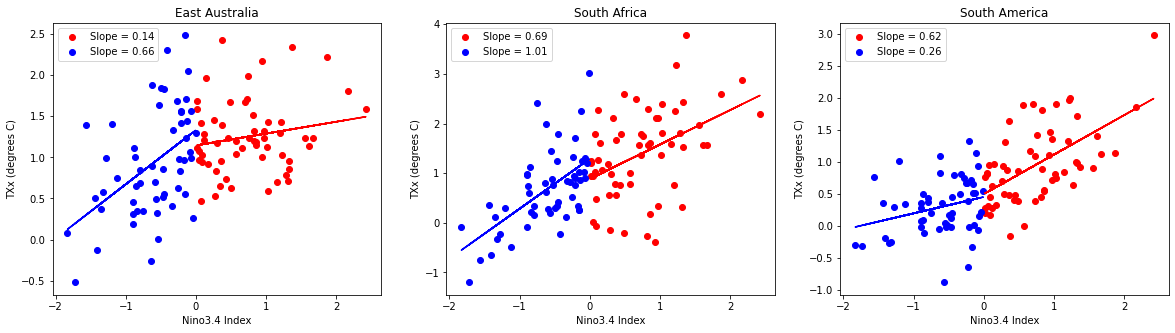

In [21]:
fig=plt.figure(figsize=(20,5))

# East Aus 
ax1=fig.add_subplot(131)
m, b = np.polyfit(pos_nino, east_aus_pos_nino_TXx.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, east_aus_neg_nino_TXx.mean(dim='member'), 1)
ax1.scatter(pos_nino, east_aus_pos_nino_TXx.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax1.scatter(neg_nino, east_aus_neg_nino_TXx.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax1.plot(pos_nino, m*pos_nino + b, c='r')
ax1.plot(neg_nino, k*neg_nino + c, c='b')
ax1.title.set_text('East Australia')
ax1.set_xlabel('Nino3.4 Index')
ax1.set_ylabel('TXx (degrees C)')
ax1.legend()

# South Africa 
ax2=fig.add_subplot(132)
m, b = np.polyfit(pos_nino, south_africa_pos_nino_TXx.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_africa_neg_nino_TXx.mean(dim='member'), 1)
ax2.scatter(pos_nino, south_africa_pos_nino_TXx.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax2.scatter(neg_nino, south_africa_neg_nino_TXx.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax2.plot(pos_nino, m*pos_nino + b, c='r')
ax2.plot(neg_nino, k*neg_nino + c, c='b')
ax2.title.set_text('South Africa')
ax2.set_xlabel('Nino3.4 Index')
ax2.set_ylabel('TXx (degrees C)')
ax2.legend()

# South America 
ax3=fig.add_subplot(133)
m, b = np.polyfit(pos_nino, south_america_pos_nino_TXx.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_america_neg_nino_TXx.mean(dim='member'), 1)
ax3.scatter(pos_nino, south_america_pos_nino_TXx.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax3.scatter(neg_nino, south_america_neg_nino_TXx.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax3.plot(pos_nino, m*pos_nino + b, c='r')
ax3.plot(neg_nino, k*neg_nino + c, c='b')
ax3.title.set_text('South America')
ax3.set_xlabel('Nino3.4 Index')
ax3.set_ylabel('TXx (degrees C)')
ax3.legend()

# plt.savefig('asymmetry_txx_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### TNn composites 

In [ ]:
TNn = xr.open_dataarray('/g/data/w40/rl5183/progress_files/TNn_detrended.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))
# Add season year axis 
func.seasonyear(TNn)
# Calculate seasonal means 
seasonal_TNn = TNn.groupby('seasonyear').apply(func.seasonal_min)

In [ ]:
#select out each season
TNn_jja = seasonal_TNn.sel(season='JJA')
TNn_son = seasonal_TNn.sel(season='SON')
TNn_djf = seasonal_TNn.sel(season='DJF')
TNn_mam = seasonal_TNn.sel(season='MAM')

In [ ]:
# Select out regional boxes and take lat long mean  
east_aus = TNn_djf.sel(lat=slice(-40,-10)).sel(lon=slice(139,154)).mean(dim=['lat','lon'])
south_africa = TNn_djf.sel(lat=slice(-30,-20)).sel(lon=slice(20,30)).mean(dim=['lat','lon'])
south_america = TNn_djf.sel(lat=slice(-10,10)).sel(lon=slice(280,310)).mean(dim=['lat','lon'])

In [ ]:
# Seperate into positive and negative halves 
east_aus_pos_nino_TNn = east_aus.where(nino_djf>0, drop=True)
east_aus_neg_nino_TNn = east_aus.where(nino_djf<0, drop=True)
south_africa_pos_nino_TNn = south_africa.where(nino_djf>0, drop=True)
south_africa_neg_nino_TNn = south_africa.where(nino_djf<0, drop=True)
south_america_pos_nino_TNn = south_america.where(nino_djf>0, drop=True)
south_america_neg_nino_TNn = south_america.where(nino_djf<0, drop=True)

In [ ]:
# Save data as netcdfs 
east_aus_pos_nino_TNn.to_netcdf('east_aus_pos_nino_TNn.nc')
east_aus_neg_nino_TNn.to_netcdf('east_aus_neg_nino_TNn.nc')
south_africa_pos_nino_TNn.to_netcdf('south_africa_pos_nino_TNn.nc')
south_africa_neg_nino_TNn.to_netcdf('south_africa_neg_nino_TNn.nc')
south_america_pos_nino_TNn.to_netcdf('south_america_pos_nino_TNn.nc')
south_america_neg_nino_TNn.to_netcdf('south_america_neg_nino_TNn.nc')

In [9]:
east_aus_pos_nino_TNn = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_pos_nino_TNn.nc')
east_aus_neg_nino_TNn = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_neg_nino_TNn.nc')
south_africa_pos_nino_TNn = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_pos_nino_TNn.nc')
south_africa_neg_nino_TNn = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_neg_nino_TNn.nc')
south_america_pos_nino_TNn = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_pos_nino_TNn.nc')
south_america_neg_nino_TNn = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_neg_nino_TNn.nc')

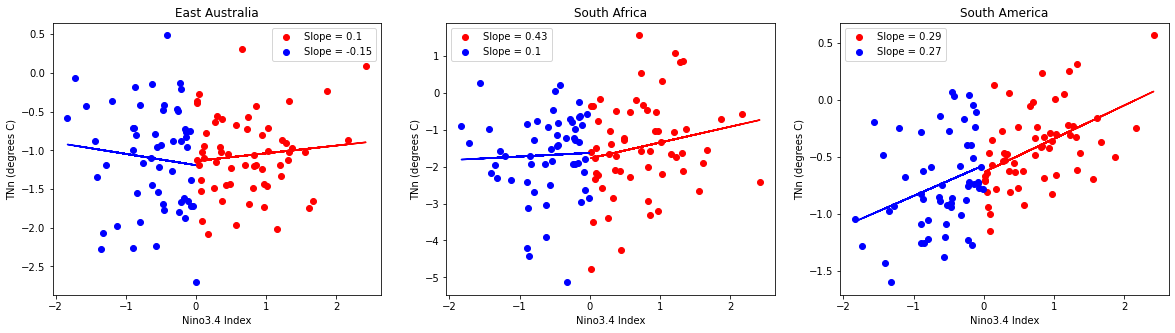

In [23]:
fig=plt.figure(figsize=(20,5))

# East Aus 
ax1=fig.add_subplot(131)
m, b = np.polyfit(pos_nino, east_aus_pos_nino_TNn.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, east_aus_neg_nino_TNn.mean(dim='member'), 1)
ax1.scatter(pos_nino, east_aus_pos_nino_TNn.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax1.scatter(neg_nino, east_aus_neg_nino_TNn.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax1.plot(pos_nino, m*pos_nino + b, c='r')
ax1.plot(neg_nino, k*neg_nino + c, c='b')
ax1.title.set_text('East Australia')
ax1.set_xlabel('Nino3.4 Index')
ax1.set_ylabel('TNn (degrees C)')
ax1.legend()

# South Africa 
ax2=fig.add_subplot(132)
m, b = np.polyfit(pos_nino, south_africa_pos_nino_TNn.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_africa_neg_nino_TNn.mean(dim='member'), 1)
ax2.scatter(pos_nino, south_africa_pos_nino_TNn.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax2.scatter(neg_nino, south_africa_neg_nino_TNn.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax2.plot(pos_nino, m*pos_nino + b, c='r')
ax2.plot(neg_nino, k*neg_nino + c, c='b')
ax2.title.set_text('South Africa')
ax2.set_xlabel('Nino3.4 Index')
ax2.set_ylabel('TNn (degrees C)')
ax2.legend()

# South America 
ax3=fig.add_subplot(133)
m, b = np.polyfit(pos_nino, south_america_pos_nino_TNn.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_america_neg_nino_TNn.mean(dim='member'), 1)
ax3.scatter(pos_nino, south_america_pos_nino_TNn.mean(dim='member'), c='red', label=f'Slope = {round(m, 2)}')
ax3.scatter(neg_nino, south_america_neg_nino_TNn.mean(dim='member'), c='blue', label=f'Slope = {round(k, 2)}')
ax3.plot(pos_nino, m*pos_nino + b, c='r')
ax3.plot(neg_nino, k*neg_nino + c, c='b')
ax3.title.set_text('South America')
ax3.set_xlabel('Nino3.4 Index')
ax3.set_ylabel('TNn (degrees C)')
ax3.legend()

# plt.savefig('asymmetry_tnn_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Rx1day composites 

In [ ]:
Rx1 = xr.open_dataarray('/g/data/w40/rl5183/20CR/precip/monthly_Rx1day_all_members_1x1.nc', chunks={'member':1}).sel(time=slice('1901-6', '2015-5'))*86400

In [ ]:
# Add season year axis 
func.seasonyear(Rx1)
# Calculate seasonal means 
seasonal_Rx1 = Rx1.groupby('seasonyear').apply(func.seasonal_max)

In [ ]:
#select out each season
Rx1_jja = seasonal_Rx1.sel(season='JJA')
Rx1_son = seasonal_Rx1.sel(season='SON')
Rx1_djf = seasonal_Rx1.sel(season='DJF')
Rx1_mam = seasonal_Rx1.sel(season='MAM')

In [ ]:
# Select out regional boxes and take lat long mean  
east_aus = Rx1_djf.sel(lat=slice(-40,-10)).sel(lon=slice(139,154)).mean(dim=['lat','lon'])
south_africa = Rx1_djf.sel(lat=slice(-30,-20)).sel(lon=slice(20,30)).mean(dim=['lat','lon'])
south_america = Rx1_djf.sel(lat=slice(-10,10)).sel(lon=slice(280,310)).mean(dim=['lat','lon'])

In [ ]:
# Seperate into positive and negative halves 
east_aus_pos_nino_Rx1 = east_aus.where(nino_djf>0, drop=True)
east_aus_neg_nino_Rx1 = east_aus.where(nino_djf<0, drop=True)
south_africa_pos_nino_Rx1 = south_africa.where(nino_djf>0, drop=True)
south_africa_neg_nino_Rx1 = south_africa.where(nino_djf<0, drop=True)
south_america_pos_nino_Rx1 = south_america.where(nino_djf>0, drop=True)
south_america_neg_nino_Rx1 = south_america.where(nino_djf<0, drop=True)

In [ ]:
# Save data as netcdfs 
east_aus_pos_nino_Rx1.to_netcdf('east_aus_pos_nino_Rx1.nc')
east_aus_neg_nino_Rx1.to_netcdf('east_aus_neg_nino_Rx1.nc')
south_africa_pos_nino_Rx1.to_netcdf('south_africa_pos_nino_Rx1.nc')
south_africa_neg_nino_Rx1.to_netcdf('south_africa_neg_nino_Rx1.nc')
south_america_pos_nino_Rx1.to_netcdf('south_america_pos_nino_Rx1.nc')
south_america_neg_nino_Rx1.to_netcdf('south_america_neg_nino_Rx1.nc')

In [11]:
east_aus_pos_nino_Rx1 = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_pos_nino_Rx1.nc')
east_aus_neg_nino_Rx1 = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/east_aus_neg_nino_Rx1.nc')
south_africa_pos_nino_Rx1 = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_pos_nino_Rx1.nc')
south_africa_neg_nino_Rx1 = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_africa_neg_nino_Rx1.nc')
south_america_pos_nino_Rx1 = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_pos_nino_Rx1.nc')
south_america_neg_nino_Rx1 = xr.open_dataarray('/home/563/rl5183/PhD-research/Working/temp files/south_america_neg_nino_Rx1.nc')

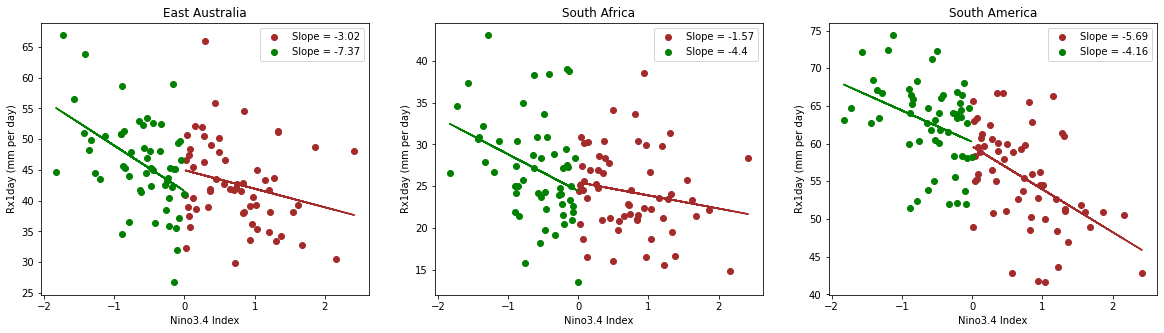

In [25]:
fig=plt.figure(figsize=(20,5))

# East Aus 
ax1=fig.add_subplot(131)
m, b = np.polyfit(pos_nino, east_aus_pos_nino_Rx1.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, east_aus_neg_nino_Rx1.mean(dim='member'), 1)
ax1.scatter(pos_nino, east_aus_pos_nino_Rx1.mean(dim='member'), c='brown', label=f'Slope = {round(m, 2)}')
ax1.scatter(neg_nino, east_aus_neg_nino_Rx1.mean(dim='member'), c='green', label=f'Slope = {round(k, 2)}')
ax1.plot(pos_nino, m*pos_nino + b, c='brown')
ax1.plot(neg_nino, k*neg_nino + c, c='green')
ax1.title.set_text('East Australia')
ax1.set_xlabel('Nino3.4 Index')
ax1.set_ylabel('Rx1day (mm per day)')
ax1.legend()

# South Africa 
ax2=fig.add_subplot(132)
m, b = np.polyfit(pos_nino, south_africa_pos_nino_Rx1.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_africa_neg_nino_Rx1.mean(dim='member'), 1)
ax2.scatter(pos_nino, south_africa_pos_nino_Rx1.mean(dim='member'), c='brown', label=f'Slope = {round(m, 2)}')
ax2.scatter(neg_nino, south_africa_neg_nino_Rx1.mean(dim='member'), c='green', label=f'Slope = {round(k, 2)}')
ax2.plot(pos_nino, m*pos_nino + b, c='brown')
ax2.plot(neg_nino, k*neg_nino + c, c='green')
ax2.title.set_text('South Africa')
ax2.set_xlabel('Nino3.4 Index')
ax2.set_ylabel('Rx1day (mm per day)')
ax2.legend()

# South America 
ax3=fig.add_subplot(133)
m, b = np.polyfit(pos_nino, south_america_pos_nino_Rx1.mean(dim='member'), 1)
k, c = np.polyfit(neg_nino, south_america_neg_nino_Rx1.mean(dim='member'), 1)
ax3.scatter(pos_nino, south_america_pos_nino_Rx1.mean(dim='member'), c='brown', label=f'Slope = {round(m, 2)}')
ax3.scatter(neg_nino, south_america_neg_nino_Rx1.mean(dim='member'), c='green', label=f'Slope = {round(k, 2)}')
ax3.plot(pos_nino, m*pos_nino + b, c='brown')
ax3.plot(neg_nino, k*neg_nino + c, c='green')
ax3.title.set_text('South America')
ax3.set_xlabel('Nino3.4 Index')
ax3.set_ylabel('Rx1day (mm per day)')
ax3.legend()

# plt.savefig('asymmetry_rx1_djf.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)